## Iteration 1
---

Combined Code 1,2,3 from the lecture

### Target
- Have a basic working code
- Have a skeleton code to build upon
- Make it as light as possible without adding any normalisation, regularisation, etc.

### Results

- Parameters: 9.6k
- Best Train accuracy: 99.15
- Best Test accuracy: 98.85

### Analysis

- Good model
- No overfitting
- Can be better if trained more

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
SEED = 69

torch.manual_seed(SEED)

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) # 28>26 | 3
        self.conv2 = nn.Conv2d(8, 8, 3) # 26 > 24 |  5
        self.conv3 = nn.Conv2d(8, 8, 3) # 24> 22 | 7
        self.pool2 = nn.MaxPool2d(2, 2) # 22 > 11 | 14
        self.conv4 = nn.Conv2d(8, 16, 3) #11 > 9 | 16
        self.conv5 = nn.Conv2d(16, 16, 3) # 9 > 7 | 18
        self.conv6 = nn.Conv2d(16, 16, 3) # 7 > 5 | 20
        self.conv7 = nn.Conv2d(16, 10, 5) # 5 > 1 | 24 | > 1x1x10

    def forward(self, x):
        # x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.pool2(F.relu(self.conv3(x)))
        x = F.relu(self.conv6(F.relu(self.conv5(F.relu(self.conv4(x))))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

In [17]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2            [-1, 8, 24, 24]             584
            Conv2d-3            [-1, 8, 22, 22]             584
         MaxPool2d-4            [-1, 8, 11, 11]               0
            Conv2d-5             [-1, 16, 9, 9]           1,168
            Conv2d-6             [-1, 16, 7, 7]           2,320
            Conv2d-7             [-1, 16, 5, 5]           2,320
            Conv2d-8             [-1, 10, 1, 1]           4,010
Total params: 11,066
Trainable params: 11,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.04
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []

train_acc = []
test_acc = []

def train(model, device, train_loader, optimiser):
  model.train()

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)

    optimiser.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    loss.backward()
    optimiser.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:

      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
model = Net().to(device)

optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

for epoch in range(EPOCHS):
  print("epoch:", epoch)
  train(model, device, train_loader, optimiser)
  test(model, device, test_loader)

epoch: 0


Loss=0.11762538552284241 Batch_id=468 Accuracy=67.97: 100%|██████████| 469/469 [00:04<00:00, 100.02it/s]



Test set: Average loss: 0.1722, Accuracy: 9468/10000 (94.68%)

epoch: 1


Loss=0.15002302825450897 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:04<00:00, 110.10it/s] 



Test set: Average loss: 0.1153, Accuracy: 9598/10000 (95.98%)

epoch: 2


Loss=0.04847755655646324 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:04<00:00, 109.16it/s] 



Test set: Average loss: 0.0596, Accuracy: 9813/10000 (98.13%)

epoch: 3


Loss=0.09818201512098312 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:04<00:00, 107.97it/s] 



Test set: Average loss: 0.0550, Accuracy: 9814/10000 (98.14%)

epoch: 4


Loss=0.03609834238886833 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:04<00:00, 113.38it/s]  



Test set: Average loss: 0.0490, Accuracy: 9850/10000 (98.50%)

epoch: 5


Loss=0.02390495128929615 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:04<00:00, 109.09it/s]  



Test set: Average loss: 0.0442, Accuracy: 9837/10000 (98.37%)

epoch: 6


Loss=0.04334212467074394 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:04<00:00, 96.84it/s]   



Test set: Average loss: 0.0445, Accuracy: 9861/10000 (98.61%)

epoch: 7


Loss=0.006447406020015478 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:04<00:00, 106.70it/s] 



Test set: Average loss: 0.0451, Accuracy: 9848/10000 (98.48%)

epoch: 8


Loss=0.019937047734856606 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:04<00:00, 110.24it/s] 



Test set: Average loss: 0.0392, Accuracy: 9871/10000 (98.71%)

epoch: 9


Loss=0.0035202940925955772 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:04<00:00, 110.52it/s]



Test set: Average loss: 0.0376, Accuracy: 9879/10000 (98.79%)

epoch: 10


Loss=0.056921884417533875 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:04<00:00, 106.21it/s] 



Test set: Average loss: 0.0413, Accuracy: 9870/10000 (98.70%)

epoch: 11


Loss=0.055616822093725204 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:04<00:00, 109.27it/s] 



Test set: Average loss: 0.0480, Accuracy: 9837/10000 (98.37%)

epoch: 12


Loss=0.00807684101164341 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:04<00:00, 110.39it/s]  



Test set: Average loss: 0.0399, Accuracy: 9880/10000 (98.80%)

epoch: 13


Loss=0.016791222617030144 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:04<00:00, 107.38it/s] 



Test set: Average loss: 0.0407, Accuracy: 9869/10000 (98.69%)

epoch: 14


Loss=0.014878119342029095 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:04<00:00, 106.27it/s]  



Test set: Average loss: 0.0376, Accuracy: 9879/10000 (98.79%)



Text(0.5, 1.0, 'Test Accuracy')

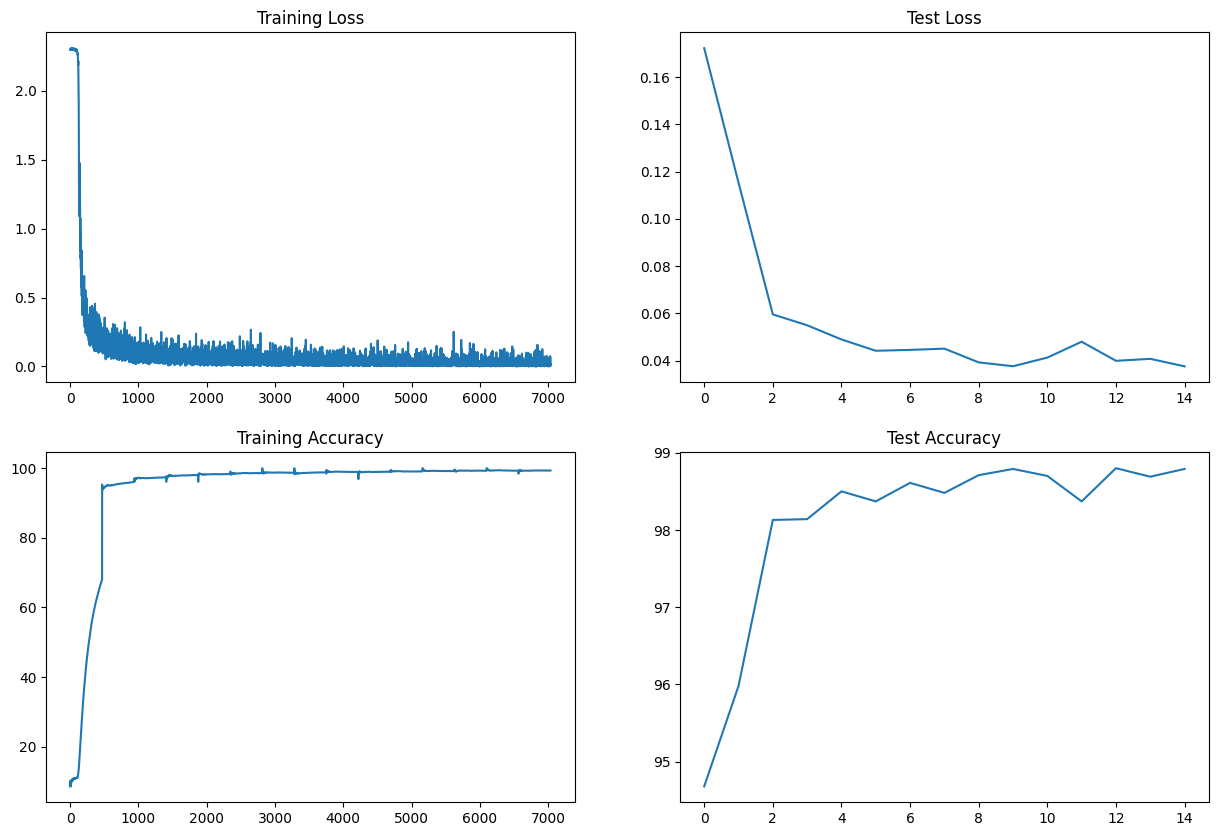

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")